In [125]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
text = pd.read_csv("Form_data.csv")

In [3]:
text.head()

,Unnamed: 0,0,id
0,0,Grant Application Form ~ Support to Individual...,72006731084146
1,1,Tokyo International Art Fair | 東京インターナショナルア...,202624875408358
2,2,"Essential Information:,Shipping Address:,Signa...",80765808251966
3,3,"Applicant Information,Name,Email,Phone Number,...",91284669088169
4,4,"E-mail Receipt,Payment Amount,Submit,Select Pa...",90138230803145


In [4]:
title= pd.read_csv("Form_content.csv")
title = title.loc[:,["id", "title"]]
title.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296 entries, 0 to 2295
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2292 non-null   float64
 1   title   2291 non-null   object 
dtypes: float64(1), object(1)
memory usage: 36.0+ KB


In [5]:
data = pd.merge(text, title, how='inner', on=['id'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2740 entries, 0 to 2739
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2740 non-null   int64 
 1   0           2740 non-null   object
 2   id          2740 non-null   int64 
 3   title       2739 non-null   object
dtypes: int64(2), object(2)
memory usage: 107.0+ KB


In [6]:
data = data.drop('Unnamed: 0', axis=1)
data.rename( columns = {'0':'text'}, inplace = True)
data = data.drop_duplicates().reset_index(drop=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2179 non-null   object
 1   id      2179 non-null   int64 
 2   title   2178 non-null   object
dtypes: int64(1), object(2)
memory usage: 51.2+ KB


In [8]:
data["total_text"] = data["title"].astype(str) + ", " + data["text"].astype(str)

In [9]:
data = data.drop('title', axis=1)
data = data.drop('text', axis=1)

In [10]:
def clean_text(text):
    s = BeautifulSoup(text).get_text(strip=True)
    s = s.replace('\u200b', '').replace('\n', '').replace('\xa0', '').replace("\\", '')
    return s

In [11]:
def clean_dataframe_for_text(dataframe):
    for index in range(len(dataframe.loc[:,"total_text"])):
        c_text = clean_text(dataframe.loc[index,"total_text"])
        dataframe.loc[index,"total_text"] = c_text
    return dataframe

In [12]:
data = clean_dataframe_for_text(data)

C:\Users\Gökçe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [68]:
df = pd.read_csv("Payment_Example.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282 entries, 0 to 2281
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2282 non-null   int64 
 1   cluster  2282 non-null   object
dtypes: int64(1), object(1)
memory usage: 35.8+ KB


In [69]:
df.rename( columns = {'formID':'id', 'cluster ':'cluster'}, inplace = True)
df = pd.merge(df, data, how='inner', on=['id'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2491 entries, 0 to 2490
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          2491 non-null   int64 
 1   cluster     2491 non-null   object
 2   total_text  2491 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.8+ KB


In [70]:
df = df.drop_duplicates().reset_index(drop=True)

In [71]:
sw = stopwords.words('english') 

In [72]:
# initializing punctuations and number string
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~01234567890'''
#numbers = '''01234567890'''

In [73]:
def punctuation_deleting(dataframe):
    for index in range(len(dataframe.loc[:,"total_text"])):
        for ele in dataframe.loc[index,"total_text"]:
            if ele in punc:
                dataframe.loc[index,"total_text"] = dataframe.loc[index,"total_text"].replace(ele, "  ")
    return dataframe 

In [74]:
df = punctuation_deleting(df)

In [75]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    return [stemmer.stem(word) for word in text.split()]

def lemmatizer_func(text_list):
    return [lemmatizer.lemmatize(word) for word in text_list]

def remove_freqwords(text_list):
    FREQWORDS = ['name', 'please', 'e','a', 'an','can','will', 'mail', 'email','address','number', 'payment','submit', 'phone','date','form','may','us', 'card','example', 'com','yes' , 'no','one','full','like','page','would', 'per','must']
    return [word for word in text_list if word not in FREQWORDS]

def remove_stopwords(text_list):
    return [word for word in text_list if word not in sw]


def dataframe_processing(dataframe):
    for index in range(len(dataframe.loc[:,"total_text"])):
        my_list = tokenizer(dataframe.loc[index, "total_text"])
        my_list = lemmatizer_func(my_list)
        my_list = remove_freqwords(my_list)
        my_list = remove_stopwords(my_list)
        #my_set = set(my_list)
        my_string = ' '.join(str(e) for e in my_list)
        dataframe.loc[index, "total_text"] = my_string
    return dataframe

In [76]:
df = dataframe_processing(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2228 entries, 0 to 2227
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          2228 non-null   int64 
 1   cluster     2228 non-null   object
 2   total_text  2228 non-null   object
dtypes: int64(1), object(2)
memory usage: 52.3+ KB


In [77]:
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words=sw)

In [91]:
tfidf_wm = tfidfvectorizer.fit_transform(df.loc[:,"total_text"])
features = tfidf_wm.toarray()
features.shape

(2224, 19905)

In [92]:
tfidf_tokens = tfidfvectorizer.get_feature_names()

C:\Users\Gökçe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [93]:
df_tfidfvect = pd.DataFrame(data = features, index = range(len(df)),columns = tfidf_tokens)

In [94]:
pd.DataFrame(df.cluster.unique()).values

array([['application fee'],
       ['product fee'],
       ['registration fee'],
       ['course fee'],
       ['subscription'],
       ['form not available'],
       ['service fee'],
       ['membership'],
       ['deposit fee'],
       ['donation']], dtype=object)

In [95]:
df.replace({
    "cluster": 
           {
               "service fee ":"service fee",
               "membership ": "membership",
               "not available": "form not available"
           }
           },
    inplace = True
)

In [96]:
df.to_csv("~\Desktop\JOTFORM\\Data-Training-Porject\Data.csv")

In [97]:
# Create a new column 'category_id' with encoded categories 
df['category'] = df['cluster'].factorize()[0]
category_df = df[['cluster', 'category']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(category_df.values)
id_to_category = dict(category_df[['category', 'cluster']].values)

df = df.drop_duplicates().reset_index(drop=True)
#new dataframe
df.head()

,id,cluster,total_text,category
0,72006731084146,application fee,iaca grant applic grant applic support individ...,0
1,202624875408358,application fee,tokyo intern art fair tokyo intern art fair | ...,0
2,80765808251966,application fee,itca desktop hard copi applic essenti inform s...,0
3,91284669088169,application fee,trademark order applic inform trademark inform...,0
4,90138230803145,application fee,lbmpayment tenant receipt amount select type r...,0


In [123]:
category_df

,cluster,category
0,application fee,0
8,product fee,1
42,registration fee,2
49,course fee,3
60,subscription,4
80,form not available,5
263,service fee,6
283,membership,7
454,deposit fee,8
590,donation,9


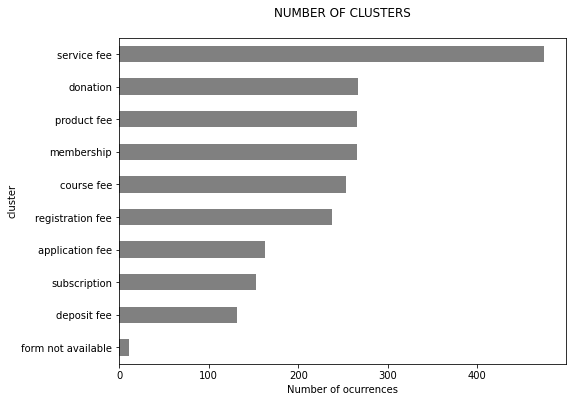

In [98]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df.groupby('cluster').id.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF CLUSTERS\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [99]:
counts_of_clusters = df.groupby('cluster').id.count().sort_values()
counts_of_clusters

cluster
form not available     11
deposit fee           132
subscription          153
application fee       163
registration fee      238
course fee            253
membership            266
product fee           266
donation              267
service fee           475
Name: id, dtype: int64

In [100]:
labels = df.category

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          2224 non-null   int64 
 1   cluster     2224 non-null   object
 2   total_text  2224 non-null   object
 3   category    2224 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 69.6+ KB


In [102]:
labels = labels.to_numpy()

In [103]:
labels.shape

(2224,)

In [104]:
features.shape

(2224, 19905)

In [105]:
X = df['total_text'] # Collection of documents
y = df['cluster'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=0.25,
                                                random_state = 0)

In [106]:
X = df['total_text'] # Collection of documents
y = df['cluster'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=0.25,
                                                random_state = 0)
X_train = X_train.values.reshape((X_train.shape[0], 1))
X_test = X_test.values.reshape((X_test.shape[0], 1))
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))
#id_to_category
models = [
#RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
LinearSVC(),
SVC(),
#MultinomialNB(),
LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [107]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
max_accuracy = cv_df.groupby('model_name').accuracy.max()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy,max_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy','Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Accuracy,Standard deviation
model_name,,,
LinearSVC,0.724397,0.783784,0.071291
LogisticRegression,0.705957,0.754505,0.054075
SVC,0.676285,0.734234,0.055867


In [108]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [109]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df['cluster'].unique()))

				CLASSIFICATIION METRICS

                    precision    recall  f1-score   support

   application fee       0.42      0.41      0.41        32
       product fee       0.86      0.78      0.82        77
  registration fee       0.55      0.59      0.57        56
        course fee       0.67      0.61      0.64        62
      subscription       0.87      0.77      0.82        35
form not available       0.00      0.00      0.00         3
       service fee       0.73      0.88      0.80       121
        membership       0.94      0.94      0.94        62
       deposit fee       0.82      0.70      0.75        33
          donation       0.99      0.93      0.96        75

          accuracy                           0.77       556
         macro avg       0.68      0.66      0.67       556
      weighted avg       0.77      0.77      0.77       556



C:\Users\Gökçe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gökçe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gökçe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: Unde

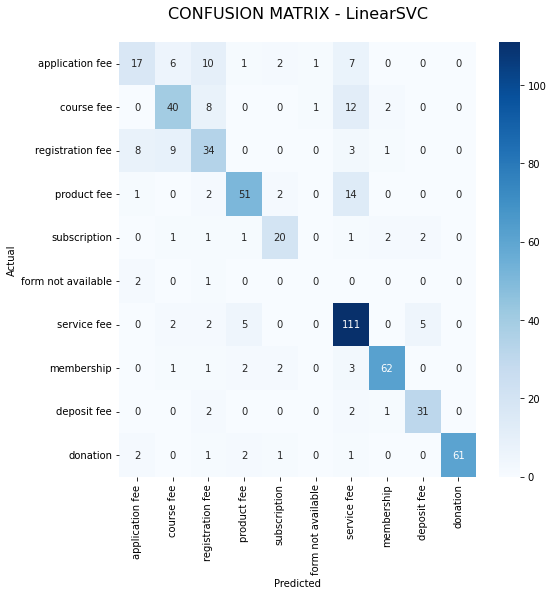

In [59]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_df.cluster.values, 
            yticklabels=category_df.cluster.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [110]:
for predicted in category_df.category:
  for actual in category_df.category:
    if predicted != actual : #and conf_mat[actual, predicted] >= 20
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['id','cluster']])
      print('')

'product fee' predicted as 'application fee' : 0 examples.


,id,cluster
1220,201005751768049,product fee
47,203613435404143,product fee



'registration fee' predicted as 'application fee' : 8 examples.


,id,cluster
1403,202925476481360,registration fee
1519,202938370615962,registration fee
56,200717431536147,registration fee
1563,201774841401147,registration fee
1464,202935945808163,registration fee
140,220175063186149,registration fee



'course fee' predicted as 'application fee' : 1 examples.


,id,cluster
325,91537051025146,course fee



'subscription' predicted as 'application fee' : 0 examples.


,id,cluster
2116,202176491277257,subscription
87,201272647249053,subscription
60,200954628973062,subscription



'form not available' predicted as 'application fee' : 2 examples.


,id,cluster



'service fee' predicted as 'application fee' : 0 examples.


,id,cluster
1768,33015591395960,service fee
2049,193453109025150,service fee



'membership' predicted as 'application fee' : 0 examples.


,id,cluster
1068,93106436521148,membership



'deposit fee' predicted as 'application fee' : 0 examples.


,id,cluster
485,201406159798059,deposit fee
464,62505448768971,deposit fee



'donation' predicted as 'application fee' : 2 examples.


,id,cluster
808,200715039832148,donation



'application fee' predicted as 'product fee' : 6 examples.


,id,cluster



'registration fee' predicted as 'product fee' : 9 examples.


,id,cluster
1603,201897049695168,registration fee
1468,203274430431141,registration fee



'course fee' predicted as 'product fee' : 0 examples.


,id,cluster
205,201674123316144,course fee



'subscription' predicted as 'product fee' : 1 examples.


,id,cluster
2090,91405015986156,subscription



'form not available' predicted as 'product fee' : 0 examples.


,id,cluster



'service fee' predicted as 'product fee' : 2 examples.


,id,cluster
1996,203554785414055,service fee
1746,203455550525149,service fee
1636,201987537784169,service fee
1783,202506252150138,service fee
2067,81188688626877,service fee



'membership' predicted as 'product fee' : 1 examples.


,id,cluster



'deposit fee' predicted as 'product fee' : 0 examples.


,id,cluster



'donation' predicted as 'product fee' : 0 examples.


,id,cluster
660,83296423153154,donation



'application fee' predicted as 'registration fee' : 10 examples.


,id,cluster
102,202395153702046,application fee
75,203531637527051,application fee
40,203030317855852,application fee
177,72895517316162,application fee
119,71087976244971,application fee
137,220175063186149,application fee
125,203585340631148,application fee
50,203581381362049,application fee
98,203515877754162,application fee
104,203584915650257,application fee



'product fee' predicted as 'registration fee' : 8 examples.


,id,cluster
1264,220881349713358,product fee



'course fee' predicted as 'registration fee' : 2 examples.


,id,cluster
368,70056301782147,course fee
370,193554489760169,course fee
421,203074721039954,course fee
270,92344567315965,course fee
363,202808476467465,course fee
439,200897322925157,course fee
331,202413625374046,course fee
299,203252707965964,course fee



'subscription' predicted as 'registration fee' : 1 examples.


,id,cluster
2137,220334933967159,subscription



'form not available' predicted as 'registration fee' : 1 examples.


,id,cluster



'service fee' predicted as 'registration fee' : 2 examples.


,id,cluster
1901,93308077855870,service fee
1410,200218523279149,service fee



'membership' predicted as 'registration fee' : 1 examples.


,id,cluster
872,220046926932153,membership
941,50715341709150,membership



'deposit fee' predicted as 'registration fee' : 2 examples.


,id,cluster
513,52344530259150,deposit fee



'donation' predicted as 'registration fee' : 1 examples.


,id,cluster
650,203557800525150,donation
763,203488544020148,donation



'application fee' predicted as 'course fee' : 1 examples.


,id,cluster
107,202653671304147,application fee
48,201345435817050,application fee
82,202637912059154,application fee



'product fee' predicted as 'course fee' : 0 examples.


,id,cluster



'registration fee' predicted as 'course fee' : 0 examples.


,id,cluster
1398,203356450186151,registration fee
1448,203516127024141,registration fee
1447,200644661087152,registration fee
1542,203444444922150,registration fee
1436,202416810223947,registration fee
1596,82655444076159,registration fee
1426,200895021356149,registration fee
1441,200815684566058,registration fee



'subscription' predicted as 'course fee' : 1 examples.


,id,cluster
2121,202892736863366,subscription



'form not available' predicted as 'course fee' : 0 examples.


,id,cluster
268,202736447354155,form not available
267,202736447354155,form not available



'service fee' predicted as 'course fee' : 5 examples.


,id,cluster
1991,72590225884160,service fee
264,202302870615346,service fee



'membership' predicted as 'course fee' : 2 examples.


,id,cluster



'deposit fee' predicted as 'course fee' : 0 examples.


,id,cluster
535,82107759484971,deposit fee
468,91767532628164,deposit fee
585,203636046703148,deposit fee



'donation' predicted as 'course fee' : 2 examples.


,id,cluster



'application fee' predicted as 'subscription' : 2 examples.


,id,cluster
126,72832534422352,application fee



'product fee' predicted as 'subscription' : 0 examples.


,id,cluster
1176,203557847384164,product fee
1172,203065230450340,product fee



'registration fee' predicted as 'subscription' : 0 examples.


,id,cluster



'course fee' predicted as 'subscription' : 2 examples.


,id,cluster
275,202665379541158,course fee



'form not available' predicted as 'subscription' : 0 examples.


,id,cluster



'service fee' predicted as 'subscription' : 0 examples.


,id,cluster



'membership' predicted as 'subscription' : 2 examples.


,id,cluster



'deposit fee' predicted as 'subscription' : 0 examples.


,id,cluster



'donation' predicted as 'subscription' : 1 examples.


,id,cluster



'application fee' predicted as 'form not available' : 1 examples.


,id,cluster



'product fee' predicted as 'form not available' : 1 examples.


,id,cluster



'registration fee' predicted as 'form not available' : 0 examples.


,id,cluster



'course fee' predicted as 'form not available' : 0 examples.


,id,cluster



'subscription' predicted as 'form not available' : 0 examples.


,id,cluster



'service fee' predicted as 'form not available' : 0 examples.


,id,cluster



'membership' predicted as 'form not available' : 0 examples.


,id,cluster



'deposit fee' predicted as 'form not available' : 0 examples.


,id,cluster



'donation' predicted as 'form not available' : 0 examples.


,id,cluster



'application fee' predicted as 'service fee' : 7 examples.


,id,cluster
65,91052445587360,application fee
6,203373338371151,application fee
161,72725168801155,application fee
3,91284669088169,application fee



'product fee' predicted as 'service fee' : 12 examples.


,id,cluster
1217,203351740528047,product fee
1131,220585317212045,product fee
1230,203084413761046,product fee
1265,220834942067155,product fee
1245,203197433183152,product fee
1286,203656394019257,product fee
1124,220409175300141,product fee
1240,203647732141451,product fee
67,91052445587360,product fee
1227,203355853687163,product fee



'registration fee' predicted as 'service fee' : 3 examples.


,id,cluster
1395,92746295233160,registration fee
1402,200943658828062,registration fee
1601,201804083884154,registration fee
1589,202787059319161,registration fee
1498,221114002369139,registration fee
1494,210484434746155,registration fee



'course fee' predicted as 'service fee' : 14 examples.


,id,cluster
406,80298120784258,course fee
258,73383075776164,course fee
306,61197181055152,course fee
367,53196047033957,course fee
303,220308306639150,course fee
396,202130368554147,course fee
453,201185282835355,course fee
375,202173107786859,course fee
382,202130538462144,course fee



'subscription' predicted as 'service fee' : 1 examples.


,id,cluster
2105,202935854563160,subscription
2149,60025498010143,subscription



'form not available' predicted as 'service fee' : 0 examples.


,id,cluster
858,201405584132143,form not available



'membership' predicted as 'service fee' : 3 examples.


,id,cluster
955,93037432680153,membership



'deposit fee' predicted as 'service fee' : 2 examples.


,id,cluster
579,202764031595354,deposit fee
586,81427559004153,deposit fee
527,92844881381366,deposit fee
558,203521470050844,deposit fee



'donation' predicted as 'service fee' : 1 examples.


,id,cluster
840,22434752493153,donation



'application fee' predicted as 'membership' : 0 examples.


,id,cluster
120,202225442861045,application fee



'product fee' predicted as 'membership' : 2 examples.


,id,cluster



'registration fee' predicted as 'membership' : 1 examples.


,id,cluster



'course fee' predicted as 'membership' : 0 examples.


,id,cluster
285,201624818698163,course fee
389,203603803228145,course fee
282,200855217908963,course fee



'subscription' predicted as 'membership' : 2 examples.


,id,cluster



'form not available' predicted as 'membership' : 0 examples.


,id,cluster



'service fee' predicted as 'membership' : 0 examples.


,id,cluster



'deposit fee' predicted as 'membership' : 1 examples.


,id,cluster



'donation' predicted as 'membership' : 0 examples.


,id,cluster



'application fee' predicted as 'deposit fee' : 0 examples.


,id,cluster



'product fee' predicted as 'deposit fee' : 0 examples.


,id,cluster



'registration fee' predicted as 'deposit fee' : 0 examples.


,id,cluster
1452,203024766458155,registration fee



'course fee' predicted as 'deposit fee' : 0 examples.


,id,cluster
321,30327508463149,course fee



'subscription' predicted as 'deposit fee' : 2 examples.


,id,cluster



'form not available' predicted as 'deposit fee' : 0 examples.


,id,cluster



'service fee' predicted as 'deposit fee' : 5 examples.


,id,cluster
1887,60978028678876,service fee
563,72774585183165,service fee
1943,90944343672159,service fee



'membership' predicted as 'deposit fee' : 0 examples.


,id,cluster



'donation' predicted as 'deposit fee' : 0 examples.


,id,cluster



'application fee' predicted as 'donation' : 0 examples.


,id,cluster



'product fee' predicted as 'donation' : 0 examples.


,id,cluster
8,33363617620148,product fee



'registration fee' predicted as 'donation' : 0 examples.


,id,cluster



'course fee' predicted as 'donation' : 0 examples.


,id,cluster



'subscription' predicted as 'donation' : 0 examples.


,id,cluster



'form not available' predicted as 'donation' : 0 examples.


,id,cluster



'service fee' predicted as 'donation' : 0 examples.


,id,cluster



'membership' predicted as 'donation' : 0 examples.


,id,cluster



'deposit fee' predicted as 'donation' : 0 examples.


,id,cluster


In [111]:
model.fit(features, labels)

LinearSVC()

In [112]:
N = 5
for cluster, category in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category])
  feature_names = np.array(tfidfvectorizer.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  print("\n==> '{}':".format(cluster))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))

C:\Users\Gökçe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> 'application fee':
  * Top unigrams: applic, trademark, smw, catchermtrx, candigirlz

==> 'course fee':
  * Top unigrams: cours, train, class, lesson, danc

==> 'deposit fee':
  * Top unigrams: deposit, parti, shorttext, blp, stfrancispetclin

==> 'donation':
  * Top unigrams: donat, contribut, give, tith, sponsorship

==> 'form not available':
  * Top unigrams: userid, entiti, satsang, br, endur

==> 'membership':
  * Top unigrams: membership, member, xgen, credenti, due

==> 'product fee':
  * Top unigrams: order, ship, product, deliveri, color

==> 'registration fee':
  * Top unigrams: registr, deleg, entri, camp, ticket

==> 'service fee':
  * Top unigrams: patient, test, client, link, offic

==> 'subscription':
  * Top unigrams: subscript, subscrib, month, hra, monthli


Prediction Time

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)


fitted_vectorizer = tfidfvectorizer.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [114]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['service fee']


In [116]:
import pickle

In [118]:
pickle_out = open("classifier.pkl", "wb")

In [120]:
pickle.dump(model,pickle_out)

In [121]:
pickle_out.close()

In [124]:
vec_file = 'vectorizer.pkl'
pickle.dump(tfidfvectorizer, open(vec_file, 'wb'))
